# Tests for conditional independance


In [24]:
# !pip install matplotlib
# !pip install statsmodels

import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Simple 3 variable linear model: 

Directed graph: 

X-->Y<--Z<--X

Model equations:

$Y = \beta_{xy} X + \beta_{zy} Z + \epsilon_{y}$

$Z = \beta_{xz} X + \epsilon_{z}$

For simulations:

Let $\epsilon$ ~ U(0,0.5), X ~ U(0,1), $\beta_{xy}=2$, $\beta_{zy}=-1$, $\beta_{xz}=1.5$

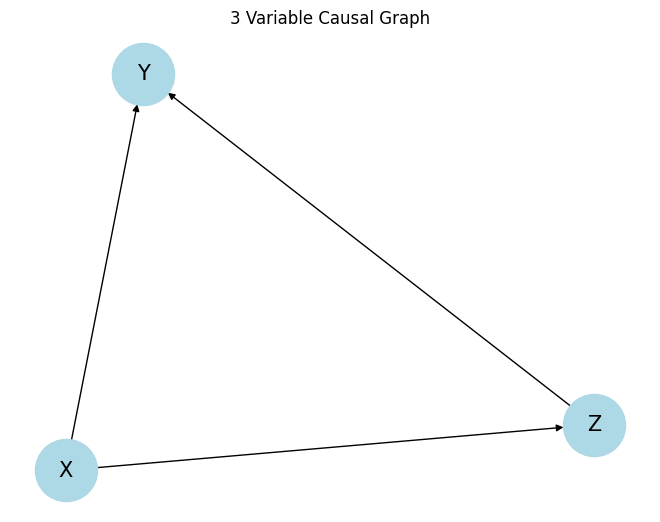

In [21]:
# Creating the causal graph
G0 = nx.DiGraph()
G0.add_edges_from([('X', 'Y'), ('Z', 'Y'), ('X', 'Z')])

# Visualizing the graph
pos = nx.spring_layout(G0)
nx.draw(G0, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=15)
plt.title("3 Variable Causal Graph")
plt.show()

estimates: 2.0065699713823637, -0.9957831622494908, 1.5413598334060714
true values: 2.0, -1.0, 1.5


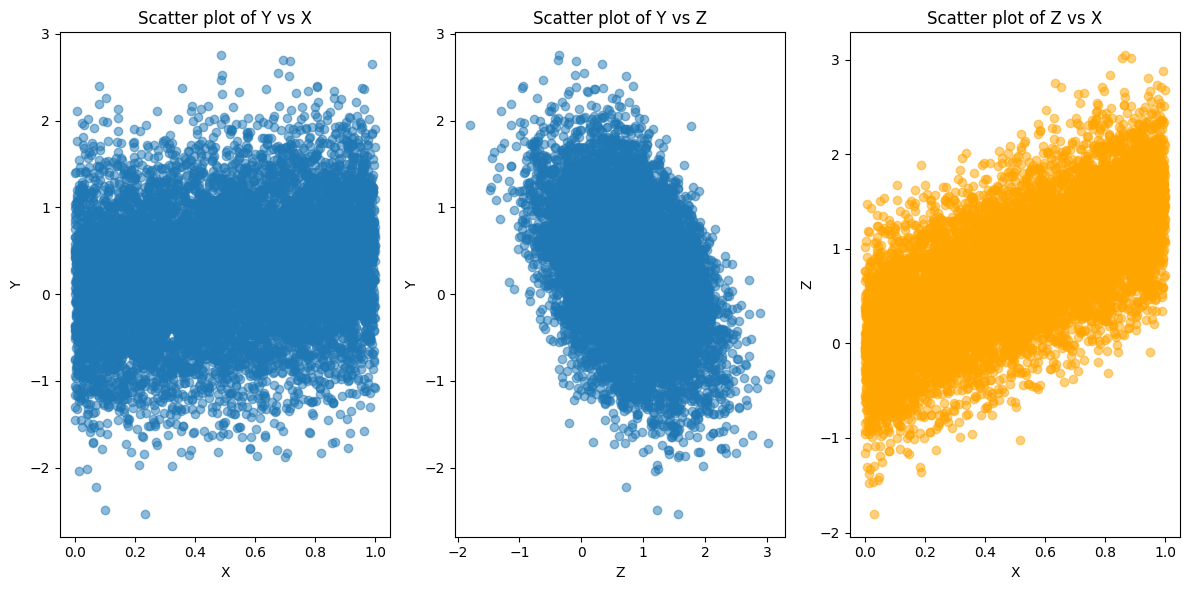

In [23]:
# Generate synthetic data, do linear regression, and plot it

# Set a random seed for reproducibility
np.random.seed(0)

# Generate synthetic data
n = 10000
X = np.random.rand(n)
epsilon_Z = np.random.randn(n) * 0.5  # smaller variance for the error term
epsilon_Y = np.random.randn(n) * 0.5

# Coefficients for the synthetic model
beta_xz = 1.5
beta_xy = 2.0
beta_zy = -1.0

# Generating Z and Y based on the model
Z = beta_xz * X + epsilon_Z
Y = beta_xy * X + beta_zy * Z + epsilon_Y

# Perform linear regression to estimate the beta values

# Prepare the data for regression
XZ = np.column_stack((X, Z))
XZ_with_intercept = sm.add_constant(XZ)  # add an intercept term

# Perform linear regression for Y on X and Z
model_Y = sm.OLS(Y, XZ_with_intercept).fit()

# Extracting estimated coefficients
estimated_beta_xy = model_Y.params[1]  # Coefficient for X
estimated_beta_zy = model_Y.params[2]  # Coefficient for Z

# The coefficient for X in the Z model needs to be estimated separately
model_Z = sm.OLS(Z, sm.add_constant(X)).fit()
estimated_beta_xz = model_Z.params[1]  # Coefficient for X in Z model

# Displaying the estimated coefficients
estimated_beta_xy, estimated_beta_zy, estimated_beta_xz
print(f'estimates: {estimated_beta_xy}, {estimated_beta_zy}, {estimated_beta_xz}')
print(f'true values: {beta_xy}, {beta_zy}, {beta_xz}')


# Plotting the data
plt.figure(figsize=(12, 6))

# Scatter plot for X and Y
plt.subplot(1, 3, 1)
plt.scatter(X, Y, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of Y vs X')

# Scatter plot for Z and Y
plt.subplot(1, 3, 2)
plt.scatter(Z, Y, alpha=0.5)
plt.xlabel('Z')
plt.ylabel('Y')
plt.title('Scatter plot of Y vs Z')

# Scatter plot for X and Z
plt.subplot(1, 3, 3)
plt.scatter(X, Z, alpha=0.5, color='orange')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Scatter plot of Z vs X')

plt.tight_layout()
plt.show()

### Meenu's model

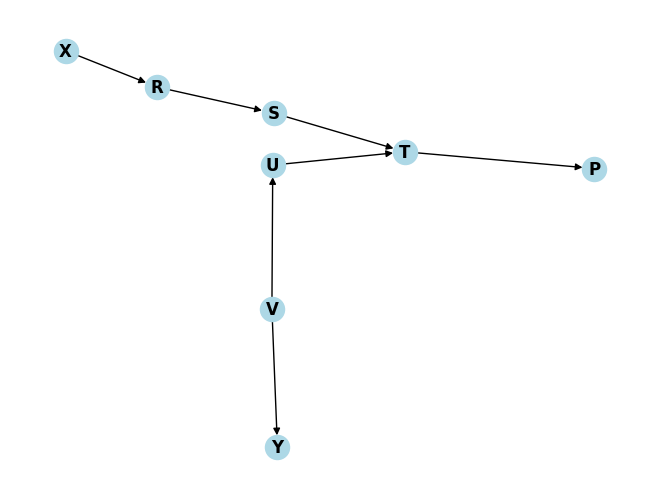

In [11]:
# graph: X -> R -> S -> T <- U <- V -> Y, T -> P
# graph edges:
# X -> R
# R -> S
# S -> T
# U -> T
# V -> U
# V -> Y
# T -> P

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
G.add_edge('X', 'R')
G.add_edge('R', 'S')
G.add_edge('S', 'T')
G.add_edge('U', 'T')
G.add_edge('V', 'U')
G.add_edge('V', 'Y')
G.add_edge('T', 'P')

# Define the layout
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color='lightblue', font_weight='bold')
plt.show()

In [ ]:
# which data to generate? 
# software tools for regression analysis